# Aperiodic Knee Simulations

In this set of simulations, we will test FOOOF's performance across power spectra simulated with a knee. 

In particular, we will simulate power spectra with a varying number of peaks, each with varying parameters, and with the aperiodic component in 'knee' mode, also across varying parameters. In these simulations we will focus on how well FOOOF performs at reconstructing the aperiodic parameters for power spectra simulated with a knee.

In [1]:
import numpy as np
from scipy.stats import spearmanr

from fooof import FOOOFGroup, fit_fooof_group_3d
from fooof.sim import gen_group_power_spectra

In [2]:
# Import project specific (local) custom code
import sys
sys.path.append('../code')
from plts import *
from sims import *
from utils import *
from analysis import *
from settings import *

## Settings

In [3]:
# Set random seed
import random
random.seed(333)

In [4]:
# Set plotting style from seaborn
import seaborn as sns
sns.set_style('white')

In [5]:
# Analysis Settings
SAVE_FIG = False
GEN_SIMS = True

### Simulate Power Spectra

In [6]:
# Set the number of power spectra - this is per noise condition
n_psds = 1000

# Set the noise levels to use
nlvs = [0.0, 0.025, 0.050, 0.10, 0.15]

# Use generators to sample peak & aperiodic parameters
peaks = gen_peak_def(None)
aps = gen_ap_kn_def()

In [7]:
# Get data sizes
n_nlvs = len(nlvs)
n_freqs = int((F_RANGE_LONG[1] - F_RANGE_LONG[0]) / F_RES_LONG + 1)

In [8]:
# Generate or load power spectra
data_name = 'knee_sims'

if GEN_SIMS:
    
    # Initialize data stores
    psds = np.empty(shape=[n_nlvs, n_psds, n_freqs])
    sim_params = [None] * n_nlvs

    # Generate simulated power spectra
    for n_ind, nlv in enumerate(nlvs):
        freqs, psds[n_ind, :, :], sim_params[n_ind] = \
            gen_group_power_spectra(n_psds, F_RANGE_LONG, aps, peaks, nlv, F_RES_LONG)
        
    # Save out generated simulated data & parameter definitions
    save_sim_data(data_name, freqs, psds, sim_params)

else:
    # Reload simulated data and parameter definitions
    freqs, psds, sim_params = load_sim_data(data_name)           
        
# Check shape
print('n_nlvs, n_spectra, n_freqs : ', psds.shape)

n_nlvs, n_spectra, n_freqs :  (5, 1000, 199)


In [9]:
# Extract ground truth values of the simulations
osc_truths, ap_truths = get_ground_truth(sim_params)

### Fit Power Spectra with FOOOF

In [10]:
# Initialize FOOOFGroup to fit with
fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, min_peak_height=0.01,
                aperiodic_mode='knee', verbose=False)

# Print out settings used for fitting simulated power spectra
fg.print_settings()

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [1, 6]                                    
                                     Max Number of Peaks : 6                                      
                                    Minimum Peak Height : 0.01                                    
                                       Peak Threshold: 2.0                                        
                                      Aperiodic Mode : knee                                       
                                                                                                  


In [11]:
# Fit power spectra - same FOOOF settings across each group of simulated power spectra
fgs = fit_fooof_group_3d(fg, freqs, psds)

### Extract FOOOF fit Data

In [12]:
# Extract data of interest from FOOOF fits
_, ap_fits, err_fits, r2_fits, n_fit_peaks = get_fit_data(fgs)

In [13]:
# Calculate error
ap_errors = calc_errors(ap_truths, ap_fits)

In [14]:
# Pull out error per aperiodic parameter
off_errors = ap_errors[:, :, 0]
kne_errors = ap_errors[:, :, 1]
exp_errors = ap_errors[:, :, 2]

### Check Average Errors & Stats

In [15]:
# Check overall fit quality
temp = r2_fits[~np.isnan(r2_fits)].flatten()
print('Min/Max R^2: \t{:1.4f} \t{:1.4f}'.format(np.min(temp), np.max(temp)))
print('Median  R^2: \t{:1.4f}'.format(np.median(temp)))

Min/Max R^2: 	0.0444 	1.0000
Median  R^2: 	0.9715


In [16]:
# Collect data together
datas = {
    'OFF' : off_errors,
    'KNE' : kne_errors,
    'EXP' : exp_errors,
    'ERR' : err_fits,
    'R^2' : r2_fits
}

In [17]:
# Print out the average error for each parameter
#   Also prints out the average model error and R^2 per noise level
for label, data in datas.items():
    print(label)
    print('\t', np.nanmedian(data, 1))

OFF
	 [0.00585238 0.05888738 0.091188   0.16579445 0.19780376]
KNE
	 [ 0.14911107  5.02040745  7.63474926 12.022166   13.67278716]
EXP
	 [0.00297588 0.0337698  0.05168072 0.09017237 0.11010138]
ERR
	 [0.0005387  0.01976838 0.0389975  0.07834478 0.11730228]
R^2
	 [0.99999048 0.99383028 0.97578562 0.90663311 0.85350928]


In [18]:
# Check if the amount of error correlates with the noise level
print('Correlations of median error with noise level:')
print('\n\t\t  r-val\t\tp-val')
print('\tOFF\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(nlvs, np.nanmedian(off_errors, axis=1))))
print('\tKNE\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(nlvs, np.nanmedian(kne_errors, axis=1))))
print('\tEXP\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(nlvs, np.nanmedian(exp_errors, axis=1))))

Correlations of median error with noise level:

		  r-val		p-val
	OFF	: 1.000 	0.00
	KNE	: 1.000 	0.00
	EXP	: 1.000 	0.00


In the correlations above, we can see that, as expected the amount of error in the model fit does correlate with the noise of the input power spectra.

### Create Plots

#### Aperiodic Components

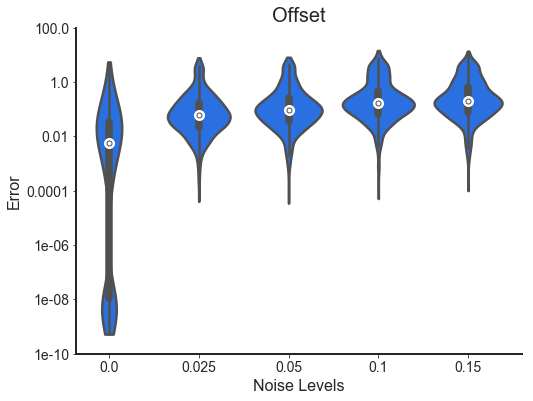

In [19]:
# Plot the error of aperiodic offset reconstruction
plot_errors_violin(off_errors, 'Offset',
                   plt_log=True, y_label=None,
                   save_fig=SAVE_FIG, save_name='Kne-Off')

../code/plts.py:56: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(data)


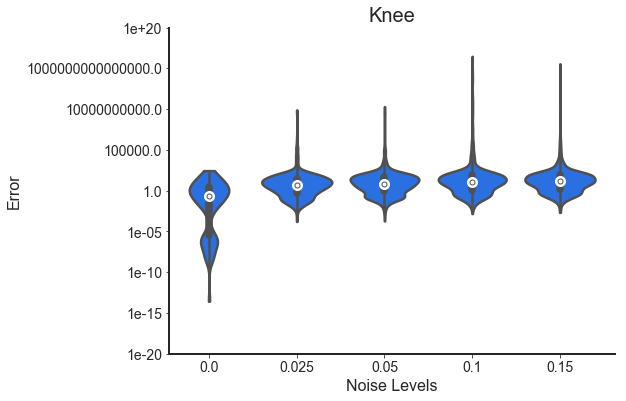

In [20]:
# Plot the error of aperiodic offset reconstruction
plot_errors_violin(kne_errors, 'Knee',
                   plt_log=True, y_label=None,
                   save_fig=SAVE_FIG, save_name='Kne-Kne')

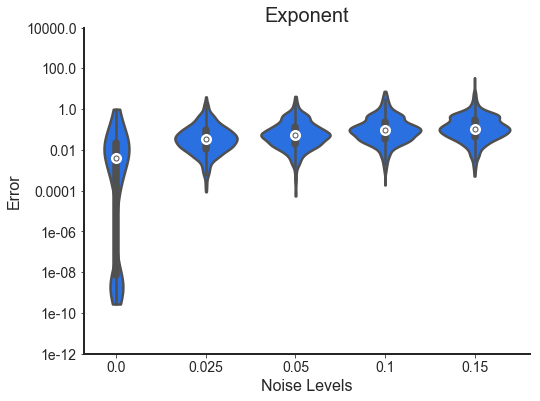

In [21]:
# Plot the error of aperiodic offset reconstruction
plot_errors_violin(exp_errors, 'Exponent',
                   plt_log=True, y_label=None,
                   save_fig=SAVE_FIG, save_name='Kne-Exp')

#### Goodness of Fit Measures

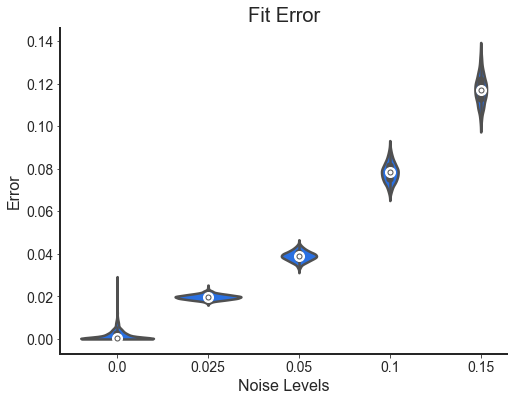

In [22]:
# Plot the amount of error across noise levels
plot_errors_violin(err_fits, 'Fit Error', plt_log=False,
                   y_label='Error',
                   save_fig=SAVE_FIG, save_name='Kne-Err')

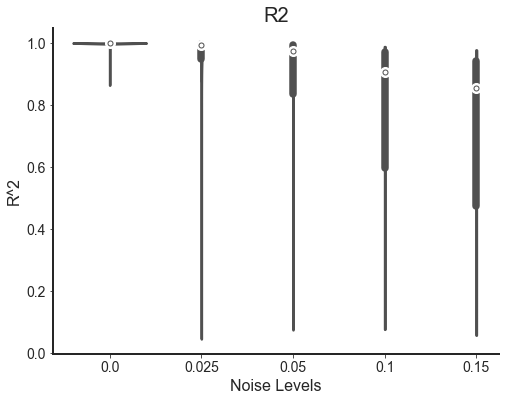

In [23]:
# Plot the goodness-of-fit (R^2) across noise levels
plot_errors_violin(r2_fits, 'R2', y_label='R^2', plt_log=False,
                   save_fig=SAVE_FIG, save_name='Kne-R2')

### Example FOOOF Fits

SimParams(aperiodic_params=[0, 150, 1.5], gaussian_params=[[11, 0.2, 1.0]], nlv=0.0)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -0.0003, 149.8324, 1.4999                                     
                                                                                                  
                        

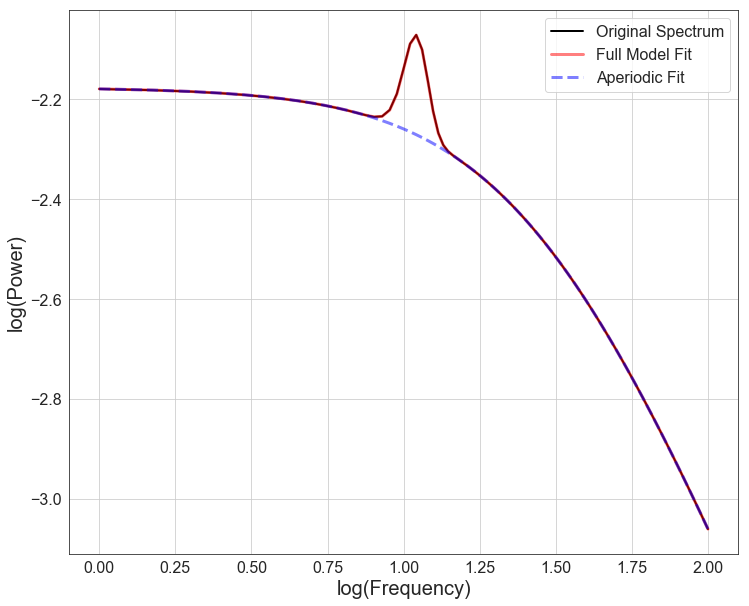

In [24]:
# Grab example cases - low noise
ind = 5
fm_nlv1 = fgs[0].get_fooof(ind, True)
print(sim_params[0][ind])
fm_nlv1.print_results()
fm_nlv1.plot(plt_log=True, save_fig=SAVE_FIG,
             file_path=FIGS_PATH, file_name='KNE-NLV1')

SimParams(aperiodic_params=[0, 25, 1.0], gaussian_params=[[5, 0.15, 3.0]], nlv=0.15)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     1.0509, 462.8448, 1.5240                                     
                                                                                                  
                        

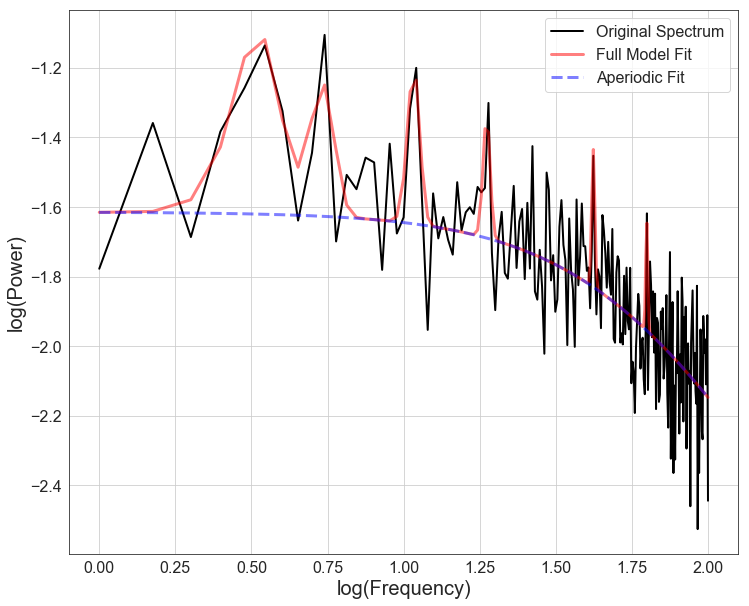

In [25]:
# Grab example cases - high noise
ind = 10
fm_nlv5 = fgs[-1].get_fooof(ind, True)
print(sim_params[-1][ind])
fm_nlv5.print_results()
fm_nlv5.plot(plt_log=True, save_fig=SAVE_FIG,
             file_path=FIGS_PATH, file_name='KNE-NLV5')